# 04. PyTorch Custom Datasets

We've used some datasets with pytorch before..

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch 
from torch import nn



In [3]:
# Setup device-agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
!nvidia-smi

Thu Jul 17 12:48:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   51C    P8              4W /   50W |     674MiB /   4096MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food anda only 10% of the images (75 training, 25 testing).

Why do this ? 

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.
The whole point is to speed up how fast you can experiment

In [7]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory already exist.... skipping download')
else:
    print(f'{image_path} does not exist, creating one....')
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
    print('Downloading pizza, steak, sushi data....')
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print("Unzipping pizza, steak and sushi data....")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exist.... skipping download
Unzipping pizza, steak and sushi data....


## 2. Becoming one with the data (data preparation and data exploration)

In [10]:
import os 
def walk_through_dir(dir_path):
    """Walks through dir_path returning it's contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

In [11]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\test.
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza.
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak.
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\train.
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza.
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak.
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi.


In [12]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an Image

Let's write some code to:
1. Get all the image paths
2. pick a random image path using Python's random.choice()
3. Get the image class name using pathlib.Path.parent.stem
4. Since we're working with images, let's oopen the image with Python's PIL
5. We'll then show the image and print metadata

Random image path: data\pizza_steak_sushi\train\pizza\786995.jpg
Image class: pizza
Image height: 384
Image width: 512


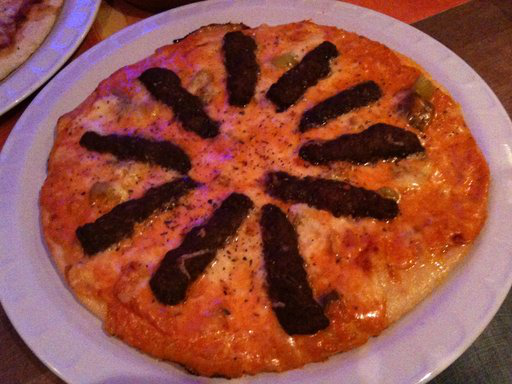

In [71]:
import random
from PIL import Image

# set seed 
#random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4.  Open image 
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img


data\pizza_steak_sushi\test\pizza\2508636.jpg

data\pizza_steak_sushi\train\pizza\2785084.jpg

data\pizza_steak_sushi\train\pizza\1105700.jpg

Text(0.5, 1.0, 'Image class: pizza | Image shape: (384, 512, 3) -> [height, widht, color_channels]')

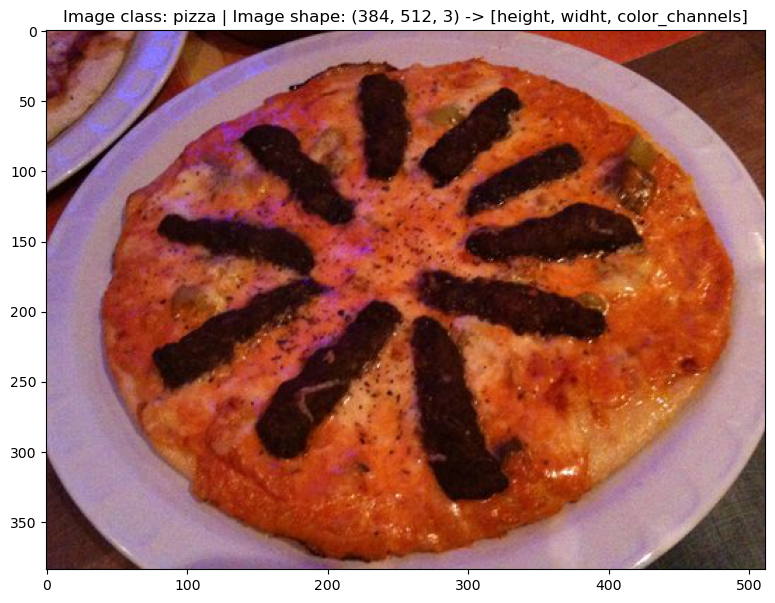

In [72]:
import numpy as np 
import matplotlib.pyplot as plt 

# Turn the image into an array 
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, widht, color_channels]')

**I Found some images confusing let's see them**

The class of each image is Pizza but 1st image is burger, second is french fries, third pizza but looks like little bit steak


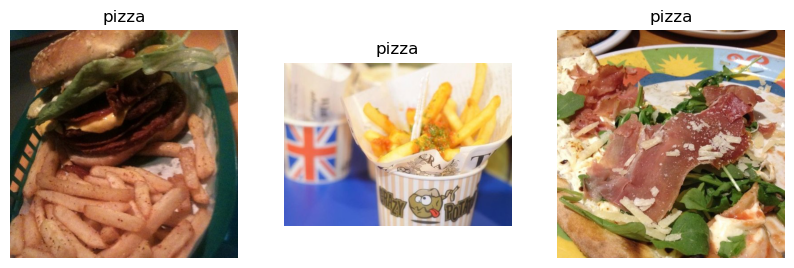

In [85]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 3, 1) 
plt.imshow(np.asarray(Image.open(r'data\pizza_steak_sushi\test\pizza\2508636.jpg')))
plt.title('pizza')
plt.axis('off')
plt.subplot(1, 3, 2) 
plt.imshow(np.asarray(Image.open(r'data\pizza_steak_sushi\train\pizza\2785084.jpg')))
plt.title('pizza')
plt.axis('off')
plt.subplot(1, 3, 3) 
plt.imshow(np.asarray(Image.open(r'data\pizza_steak_sushi\train\pizza\1105700.jpg')))
plt.title('pizza')
plt.axis('off')

print('The class of each image is Pizza but 1st image is burger, second is french fries, third pizza but looks like little bit steak')

**These images might confuse the model and make wrong predictions too**

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `Dataloader`

In [89]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 


### 3.1 Transforming data with torchvisions.transforms

Transforms help you get your images ready to be used with a model/perform data augmentation.

In [142]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64X64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [143]:
data_transform(img).shape

torch.Size([3, 64, 64])

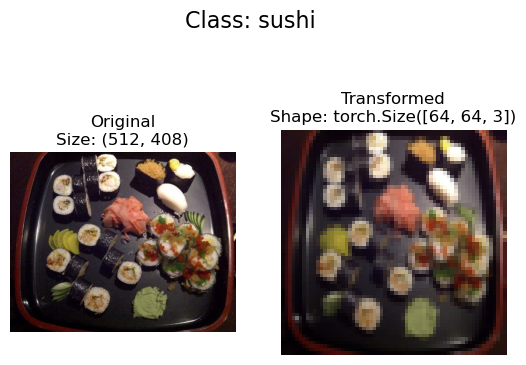

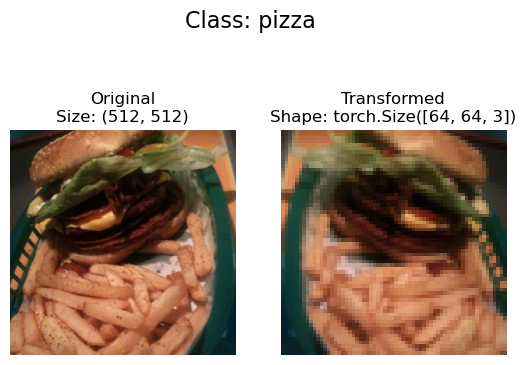

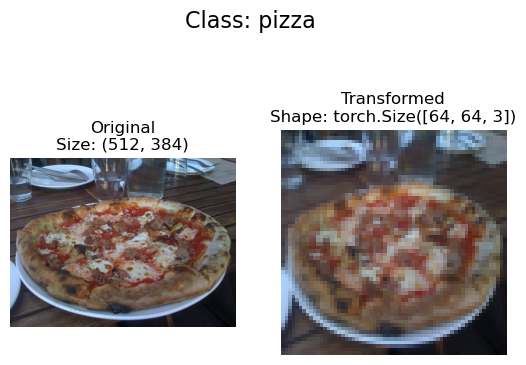

In [144]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transform them
    then plots the original vs transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis(False)

            # Transform and plot target image 
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list, 
                       transform=data_transform,
                       n=3,
                       seed=42)
            

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [146]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets 
train_data = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform, # a transform for the data
                                 target_transform=None)  # a transform for the target

test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [148]:
# Get class names as a list 
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [149]:
# Get class names as dict 
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [150]:
# Check the lengths of our dataset 
len(train_data), len(test_data)

(225, 75)

In [164]:
# Index on the train_data Dataset to get a single image and a label
img, label = train_data[1]
img, label

(tensor([[[0.7020, 0.8157, 0.8902,  ..., 0.5059, 0.4902, 0.4902],
          [0.9686, 0.9843, 0.9961,  ..., 0.5098, 0.5098, 0.5020],
          [0.9922, 0.9961, 1.0000,  ..., 0.5176, 0.4667, 0.4431],
          ...,
          [0.5137, 0.4745, 0.4627,  ..., 0.5647, 0.5569, 0.5176],
          [0.4863, 0.4824, 0.4706,  ..., 0.5020, 0.4706, 0.4824],
          [0.5098, 0.5137, 0.4980,  ..., 0.5059, 0.4314, 0.4941]],
 
         [[0.6510, 0.7961, 0.8902,  ..., 0.2902, 0.2784, 0.2784],
          [0.9529, 0.9804, 0.9961,  ..., 0.2941, 0.2902, 0.2824],
          [0.9961, 0.9961, 1.0000,  ..., 0.2980, 0.2667, 0.2627],
          ...,
          [0.1529, 0.1490, 0.1686,  ..., 0.3176, 0.2549, 0.1804],
          [0.1373, 0.1412, 0.1373,  ..., 0.1216, 0.0980, 0.1098],
          [0.1765, 0.1804, 0.1569,  ..., 0.1333, 0.0824, 0.1529]],
 
         [[0.5490, 0.7137, 0.8706,  ..., 0.1176, 0.1137, 0.1059],
          [0.9176, 0.9608, 0.9882,  ..., 0.1216, 0.1216, 0.1176],
          [0.9882, 0.9922, 0.9961,  ...,

In [165]:
img.shape

torch.Size([3, 64, 64])

In [166]:
class_names[label]

'pizza'

In [167]:
print(f'Image tensor:\n {img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatyle: {type(label)}')

Image tensor:
 tensor([[[0.7020, 0.8157, 0.8902,  ..., 0.5059, 0.4902, 0.4902],
         [0.9686, 0.9843, 0.9961,  ..., 0.5098, 0.5098, 0.5020],
         [0.9922, 0.9961, 1.0000,  ..., 0.5176, 0.4667, 0.4431],
         ...,
         [0.5137, 0.4745, 0.4627,  ..., 0.5647, 0.5569, 0.5176],
         [0.4863, 0.4824, 0.4706,  ..., 0.5020, 0.4706, 0.4824],
         [0.5098, 0.5137, 0.4980,  ..., 0.5059, 0.4314, 0.4941]],

        [[0.6510, 0.7961, 0.8902,  ..., 0.2902, 0.2784, 0.2784],
         [0.9529, 0.9804, 0.9961,  ..., 0.2941, 0.2902, 0.2824],
         [0.9961, 0.9961, 1.0000,  ..., 0.2980, 0.2667, 0.2627],
         ...,
         [0.1529, 0.1490, 0.1686,  ..., 0.3176, 0.2549, 0.1804],
         [0.1373, 0.1412, 0.1373,  ..., 0.1216, 0.0980, 0.1098],
         [0.1765, 0.1804, 0.1569,  ..., 0.1333, 0.0824, 0.1529]],

        [[0.5490, 0.7137, 0.8706,  ..., 0.1176, 0.1137, 0.1059],
         [0.9176, 0.9608, 0.9882,  ..., 0.1216, 0.1216, 0.1176],
         [0.9882, 0.9922, 0.9961,  ..., 0.1

Original shape: torch.Size([3, 64, 64]) -> [C, H , W]
Image permute: torch.Size([64, 64, 3]) -> [H, W, C]


Text(0.5, 1.0, 'pizza')

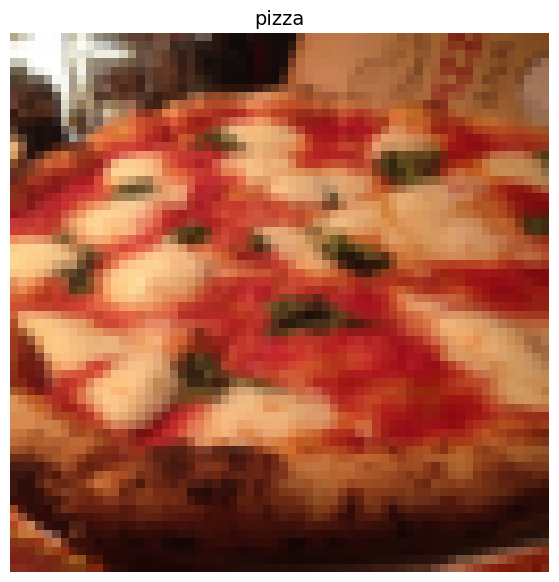

In [168]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes 
print(f'Original shape: {img.shape} -> [C, H , W]')
print(f'Image permute: {img_permute.shape} -> [H, W, C]')

# Plot the image 
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader's`

A DataLoader is going to help us turn our `Dataset` into iterables and we can customize the batch_isze so our model can see batch_size images at a time.

In [176]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1, # os.cpu_count()
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2723f7d3dc0>,
 <torch.utils.data.dataloader.DataLoader at 0x2723f7d1c00>)

In [177]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [178]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like 
print(f'Image shape: {img.shape} -> [batch_size, C, H, W]')
print(f'Label shape: {label.shape}')


Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, C, H, W]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file 
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the dataset.

Pros:
* Can create a `Dataset` out of almost anythin
* Not limited to PyTorch pre-build `Dataset` functions.

Cons: 
* Even though you could create `Dataset` out of almost anything, it does not mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues.


In [180]:
import os 
import pathlib 
import torch 

from PIL import Image
from torch.utils.data import Dataset 
from torchvision import transforms
from typing import Tuple, Dict, List

In [181]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [182]:
# Setup path for target directory
target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [191]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

    # 2. Raise an error if class names cound not be found
    if not classes:
        raise FileNotFoundError(f'Could not find any classes in {directory}... please check file structure')

    # 3. Create a directory of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes) }
    return classes, class_to_idx
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [192]:
train_dir

WindowsPath('data/pizza_steak_sushi/train')

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our image
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels.
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset.
6. Overwrite the `__getitem__()` method to return a given sample when passed an index.

In [193]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset 

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset 
    def __init__(self, targ_dir: str, 
                 transform=None):
        # 3. Create several attributes 
        # Get all of the image path
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create  a function to load images 
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Override the __len__ method(optional)
    def __len__(self) -> int:
        '''Returns the total number of samples.'''
        return len(self.paths)

    # 6. Override the __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        
        """Returns one sample of data, data and label (X, y)."""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # returns untransformed image and label




In [194]:
# Create a transform 

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms =  transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])


In [195]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                     transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transforms)

In [196]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x2723fc85390>,
 <__main__.ImageFolderCustom at 0x2723ffc8af0>)

In [198]:
len(train_data), len(train_data_custom)

(225, 225)

In [199]:
len(test_data), len(test_data_custom)

(75, 75)

In [200]:
train_data_custom.classes,

(['pizza', 'steak', 'sushi'],)

In [201]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [202]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matplotlib.
7. Make sure the dimenstions of our images line up with matplotlib(HWC)


In [208]:
# 1. Create a function to take in a dataset 
def display_random_images(dataset: torch.utils.data.Dataset,
                         classes: List[str] = None,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int = None):

    # 2. Adjust display i n is too high
    if n > 10: 
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set the seed 
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0) # [C, H, W] -> [H, W, C]

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f'Class: {classes[targ_label]}'
            if display_shape:
                title = title + f'\nshape: {targ_image_adjust.shape}'
        plt.title(title)

    
    

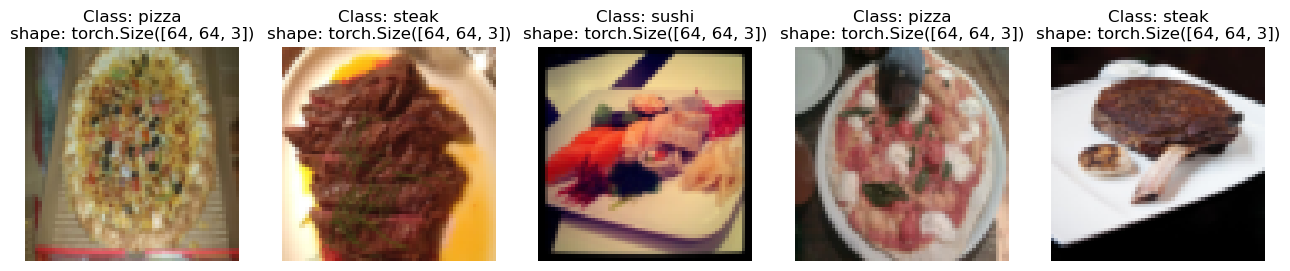

In [210]:
display_random_images(dataset=train_data,
                     classes=class_names,
                     n=5,
                     display_shape=True,
                     seed=None)

For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


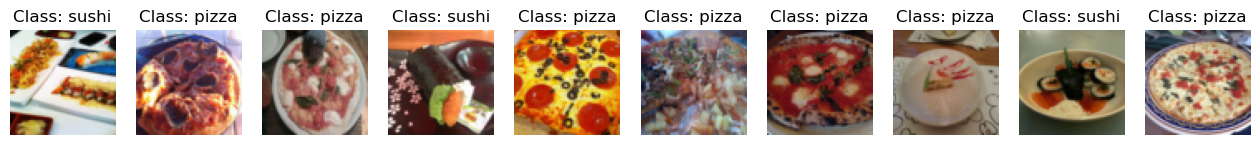

In [211]:
# # Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                     n=20,
                     classes=class_names,
                     seed=42)

### 5.4 Turn custom loaded images into `DataLoaders's`

In [212]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                   batch_size=BATCH_SIZE,
                                   num_workers=0,
                                   shuffle=False)

train_dataloader_custom, test_dataloader_custom


(<torch.utils.data.dataloader.DataLoader at 0x2723d88ebf0>,
 <torch.utils.data.dataloader.DataLoader at 0x2723d88d6f0>)

In [213]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training data.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels....

In [214]:
# Let's look at trivialaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # [0, 31]
    transforms.ToTensor()
    
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [218]:
# Get all image paths 
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

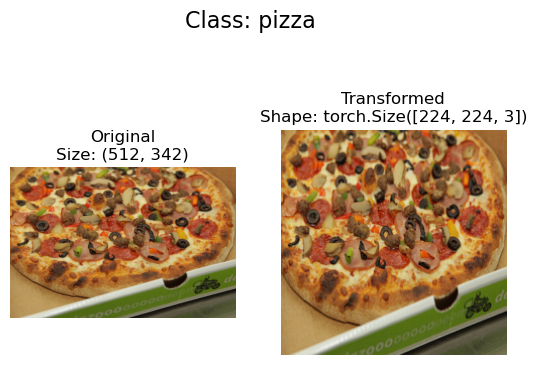

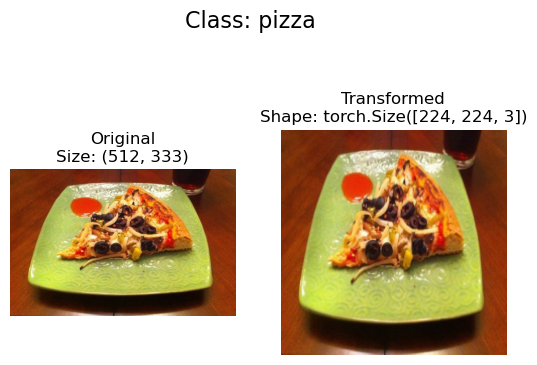

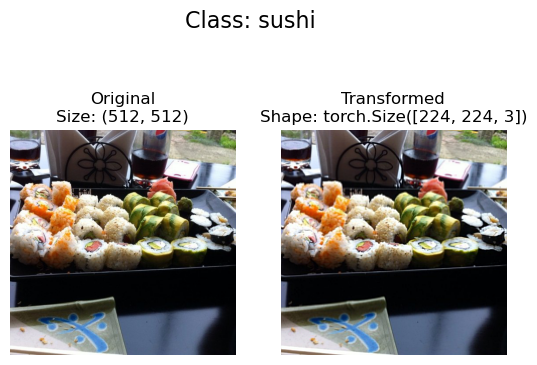

In [220]:
# Plot random transformed images 
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data from Model 0

In [221]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])


In [225]:
train_dir

WindowsPath('data/pizza_steak_sushi/train')

In [228]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform,
    target_transform=None,
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

# 2. Turn the dataset into dataloader
import os 
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create dataloader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=False)

### 7.2 Create TinyVGG Model Class

In [315]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image(to test the model)

In [283]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([1]))

In [284]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6315e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0047e-03],
        [ 2.0999e-02,  1.2868e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7293e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4455e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8265e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

In [285]:
model_0(torch.randn(1, 3, 64, 64).to(device))

tensor([[ 0.0137, -0.0225, -0.0072]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [286]:
from torchinfo import summary


In [288]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Creating train and test loops functions 

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [290]:
# Create train_step()
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device=device):
    # Put the model in train model
    model.train()

    # Setup train loss and train accuracy values 
    train_loss, train_acc = 0, 0

    # Loop through our dataloader 
    for batch, (X, y) in enumerate(dataloader):
        # Send data on the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X) # output model logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero_grad 
        optimizer.zero_grad()

        # 4. Backprop
        loss.backward()

        # 5. Gradient descent
        optimizer.step()

        # Calculate the accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    # Adjust metrics to get average loss and acc per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

# Create a test step
def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device=device):

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Put model in eval mode
    model.eval()
    # Turn the inference mode 
    with torch.inference_mode():
        # Loop through data batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # 3. Calculate the accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels==y).sum().item()/len(test_pred_logits)

        # Adjust metrics to get average loss and accuracy per batch
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine train_step() and test_step()

In [316]:
from tqdm.auto import tqdm 

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss_fn
def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
         epochs: int=5,
         device=device):
    # 2. Create empty results dictonary
    results = {'train_loss': [],
              'train_acc':[],
              'test_loss': [],
              'test_acc': []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)

        # 4. Print out what's happening
        print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

        # 5. Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    # 6. Return the filled results at the end of the epoch
    return results

### 7.7 Train and evaluate model 0

In [317]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG 
model_0 = TinyVGG(input_shape=3, 
                 hidden_units=10,
                 output_shape=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer 
from timeit import default_timer as timer 

start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                       train_dataloader=train_dataloader_simple,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3116
Epoch: 1 | Train loss: 1.0995 | Train acc: 0.3320 | Test loss: 1.0699 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0863 | Train acc: 0.4922 | Test loss: 1.0800 | Test acc: 0.5227
Epoch: 3 | Train loss: 1.0826 | Train acc: 0.4102 | Test loss: 1.0599 | Test acc: 0.5729
Epoch: 4 | Train loss: 1.0630 | Train acc: 0.4141 | Test loss: 1.0609 | Test acc: 0.5540
Epoch: 5 | Train loss: 1.0212 | Train acc: 0.4570 | Test loss: 1.0064 | Test acc: 0.4820
Epoch: 6 | Train loss: 0.9662 | Train acc: 0.4297 | Test loss: 0.9272 | Test acc: 0.6042
Epoch: 7 | Train loss: 0.9369 | Train acc: 0.5859 | Test loss: 1.0211 | Test acc: 0.4953
Epoch: 8 | Train loss: 0.9182 | Train acc: 0.5977 | Test loss: 1.0682 | Test acc: 0.3428
Epoch: 9 | Train loss: 0.9974 | Train acc: 0.4648 | Test loss: 1.0442 | Test acc: 0.3939
Total training time: 282.843 seconds


### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way to tracking your model's process over time.


In [318]:
# Get the model_0_results keys 
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [319]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (train and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    

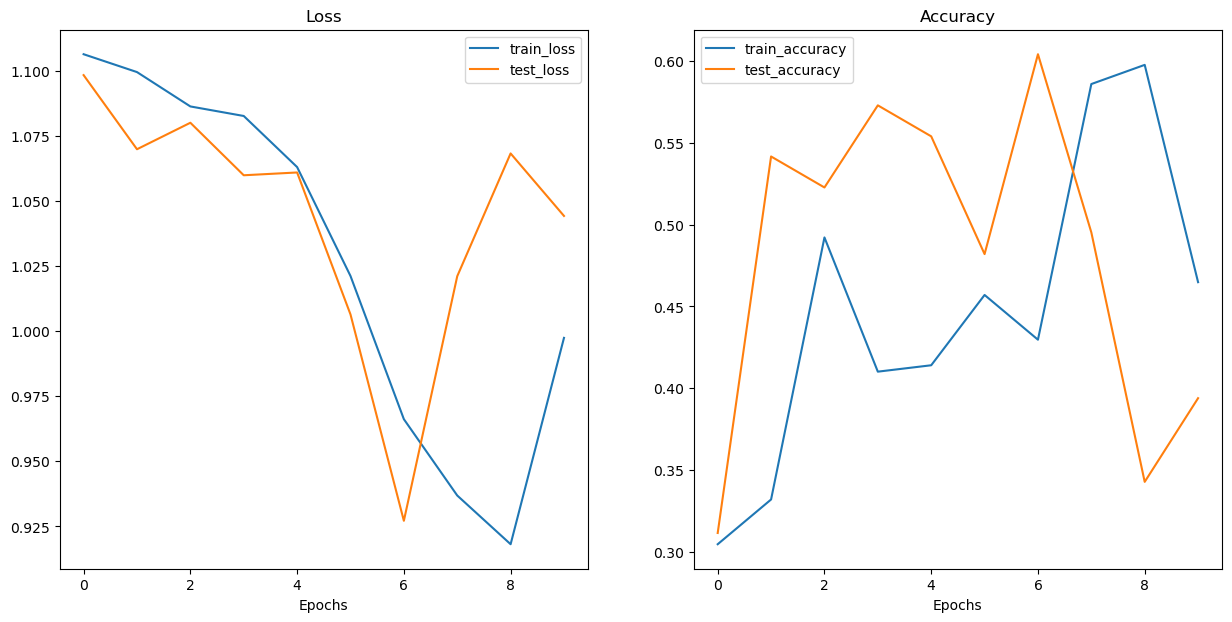

In [320]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve looks like? 

A Loss curve is one of the most helpful ways to troubleshoot a model.

https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

Method to improve a model( reduce overfitting):

- Get more data
- Data augmentation
- Better data
- Use tranfer learning
- Simplify your model
- Use learning rate decay
- Use early stopping

Method to improve a model(reduce underfitting)

- Add more layers/ units to your model
- Tweak the learning rate
- Train for longer
- Use Transfer Learning
- Use less regularization

## 9. Model 1: TinyVGG with data augmentation (one way to deal with overfitting)

Now let's try another modelling experiment this time using the same model as before but with some data augmentation.

### 9.1 Create transform with data augmentation

In [322]:
# Create training transform with TrivialAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])



### 9.2 Create train and test Datasets and DataLoaders with data augmentation

In [323]:
train_data_augmented = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial,
    target_transform=None
)

test_data_augmented = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform_simple,
    target_transform=None
)

In [324]:
# Turn our datasets into dataloaders 
import os 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                       shuffle=True,
                                       num_workers=NUM_WORKERS,
                                       batch_size=BATCH_SIZE)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS,
                                   batch_size=BATCH_SIZE)

### 9.3 Construct and train model 1 

This time we'll be using the same model architecture excepet this time we've augmented the training data.

In [325]:
# Create model_1 and send it to the target device

torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Wonderful! Now we've a model and dataloaders, let's create a loss function and an optimizer and call upon on 'train()' function to train and evaluate our model.

In [326]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f'Total Training Time for model_1: {end_time - start_time:.3f} seconds')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1046 | Train acc: 0.2500 | Test loss: 1.1016 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0764 | Train acc: 0.4258 | Test loss: 1.1301 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0733 | Train acc: 0.4258 | Test loss: 1.1678 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1217 | Train acc: 0.3047 | Test loss: 1.1551 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0771 | Train acc: 0.4609 | Test loss: 1.1509 | Test acc: 0.2812
Total Training Time for model_1: 129.932 seconds


### 9.4 Plot the loss curves of model 1 

A loss curve helps you evaluate your models performance overtime.

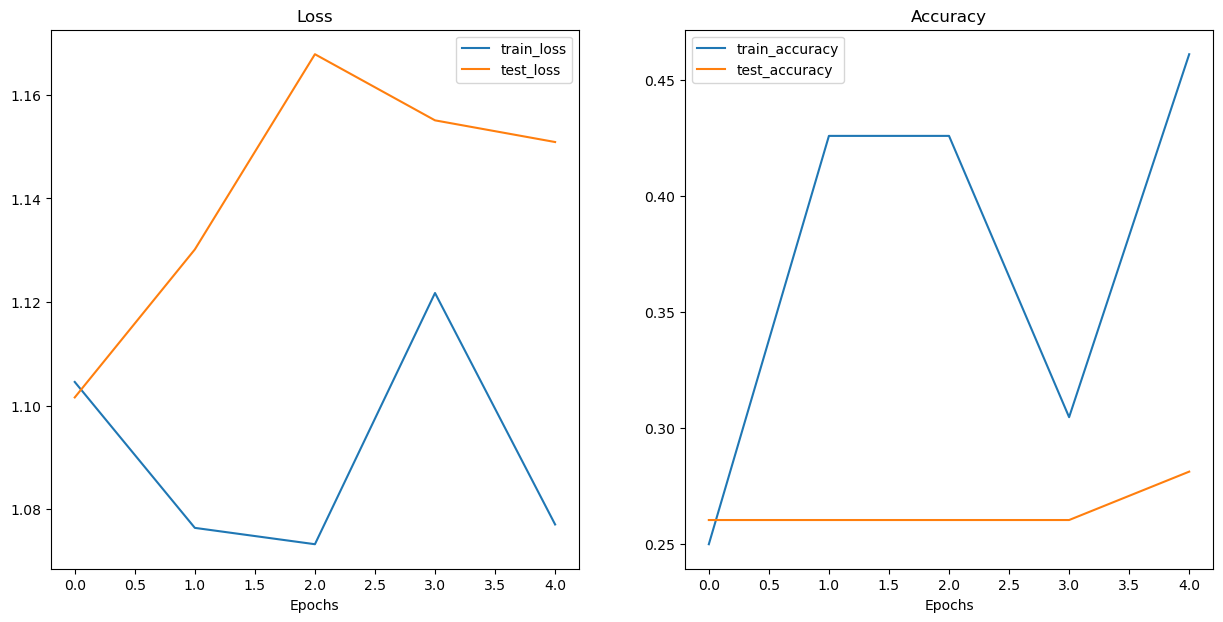

In [328]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard
3. Weights and Biases
4. MlFlow
                

In [329]:
import pandas as pd 
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df


train_loss  train_acc  test_loss  test_acc
0    1.106342   0.304688   1.098314  0.311553
1    1.099484   0.332031   1.069852  0.541667
2    1.086289   0.492188   1.080027  0.522727
3    1.082626   0.410156   1.059857  0.572917
4    1.063003   0.414062   1.060932  0.553977
5    1.021180   0.457031   1.006419  0.482008
6    0.966191   0.429688   0.927167  0.604167
7    0.936876   0.585938   1.021083  0.495265
8    0.918169   0.597656   1.068240  0.342803
9    0.997417   0.464844   1.044238  0.393939

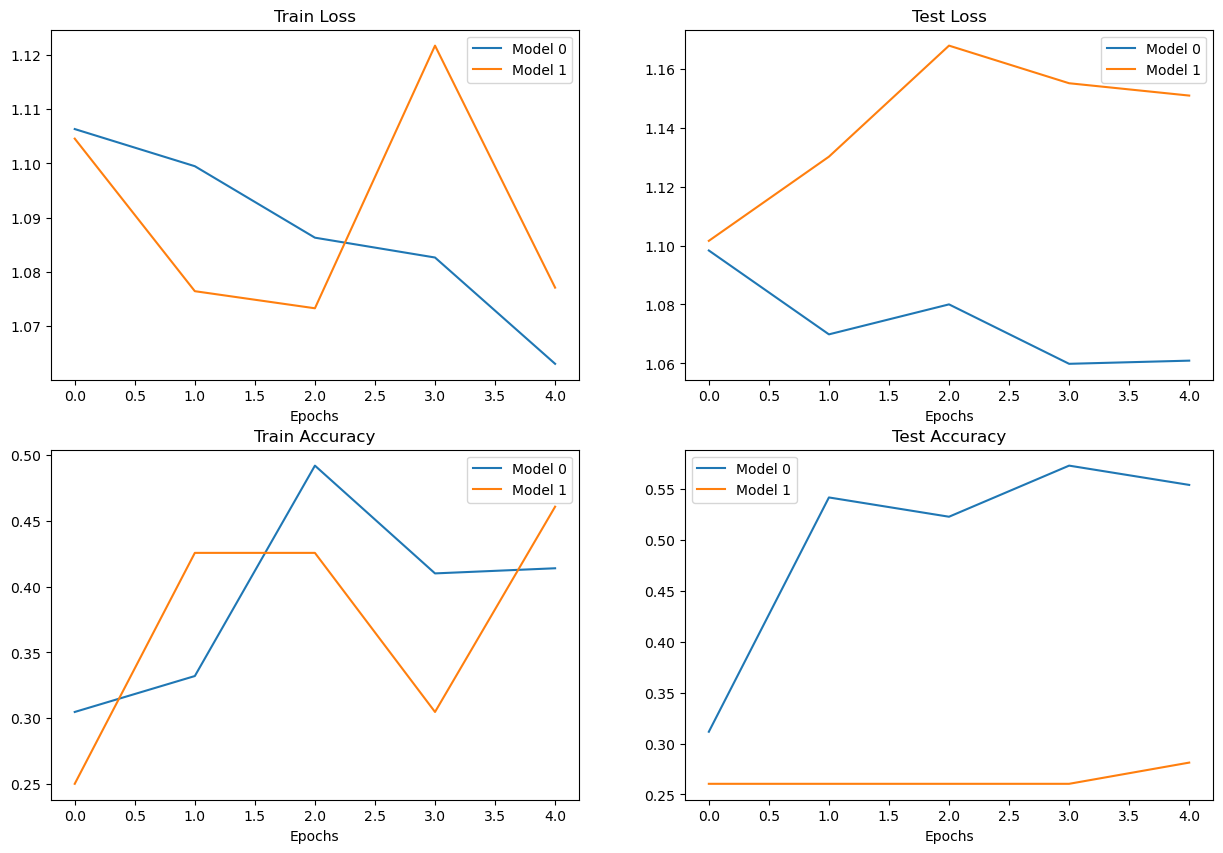

In [337]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_1_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'][:5], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.xlabel('Epochs')
plt.title('Train Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'][:5], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.xlabel('Epochs')
plt.title('Test Loss')
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'][:5], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.xlabel('Epochs')
plt.title('Train Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'][:5], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.xlabel('Epochs')
plt.title('Test Accuracy')
plt.legend()


## 11. Making a prediction on a custom image

Although we've trained a model on custom data... How do you make prediction on sample/image which is not the part of training or testing data

In [341]:
# Download custom image
import requests 

# Setup custom image path 
custom_image_path = data_path / '04-pizza-dad.jpeg'

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        # When downloading from GitHub, need to use 'raw' file link
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true')
        print(f'Downloading {custom_image_path}....')
        f.write(request.content)

else:
    print(f'{custom_image_path} already exists, skipping download...')

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with dtype (torch.float32)
* Of shape 64*64*3
* On the right device

In [350]:
import torchvision

# Read in custom image 
custom_image_uint8 = torchvision.io.read_image(custom_image_path)
print(f'Custom image tensor:\n {custom_image_uint8}')
print(f'Custom image shape: {custom_image_uint8.shape}')
print(f'Custom image datatype: {custom_image_uint8.dtype}')

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

In [348]:
custom_image_uint8.shape

torch.Size([3, 4032, 3024])

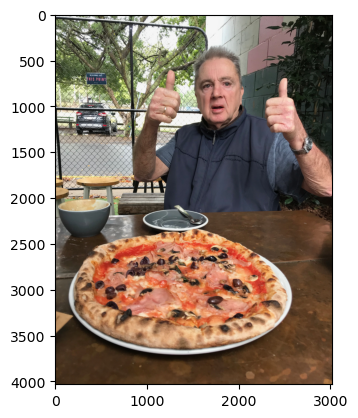

In [347]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [351]:
# Try to make a prediction on an image
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [352]:
# Load in the custom image convert to torch.float32

custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32)
custom_image

tensor([[[154., 173., 181.,  ...,  21.,  18.,  14.],
         [146., 165., 181.,  ...,  21.,  18.,  15.],
         [124., 146., 172.,  ...,  18.,  17.,  15.],
         ...,
         [ 72.,  59.,  45.,  ..., 152., 150., 148.],
         [ 64.,  55.,  41.,  ..., 150., 147., 144.],
         [ 64.,  60.,  46.,  ..., 149., 146., 143.]],

        [[171., 190., 193.,  ...,  22.,  19.,  15.],
         [163., 182., 193.,  ...,  22.,  19.,  16.],
         [141., 163., 184.,  ...,  19.,  18.,  16.],
         ...,
         [ 55.,  42.,  28.,  ..., 107., 104., 103.],
         [ 47.,  38.,  24.,  ..., 108., 104., 102.],
         [ 47.,  43.,  29.,  ..., 107., 104., 101.]],

        [[119., 138., 147.,  ...,  17.,  14.,  10.],
         [111., 130., 145.,  ...,  17.,  14.,  11.],
         [ 87., 111., 136.,  ...,  14.,  13.,  11.],
         ...,
         [ 35.,  22.,   8.,  ...,  52.,  52.,  48.],
         [ 27.,  18.,   4.,  ...,  50.,  49.,  44.],
         [ 27.,  23.,   9.,  ...,  49.,  46.,  43.]]]

In [353]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [354]:
custom_image.shape

torch.Size([3, 4032, 3024])

In [355]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image / 255)

# Print out the shapes
print(f'Original shape: {custom_image.shape}')
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


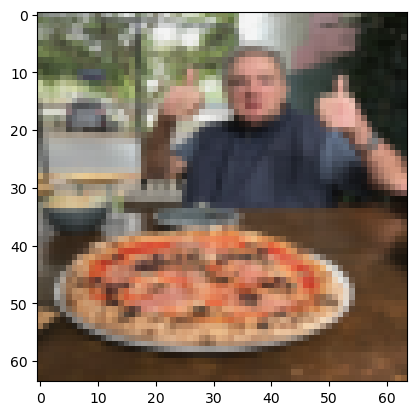

In [356]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [360]:
# This will error image not on right device
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [359]:
# This will error: no batch size
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [361]:
# This will error: no batch size
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device).unsqueeze(0))

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model(torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with batch size ... (1, 3, 64, 64)
* Make sure the image was on the same device as our model.

In [367]:
# Convert logits to prediction probs
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3663, 0.3571, 0.2766]], device='cuda:0')

In [370]:
# Convert pred probs into labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_labels

tensor([0])

In [371]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [374]:
def pred_and_plot_image(model: torch.nn.Module,
                       image_path: str,
                       class_names: List[str] = None,
                       transform=None,
                       device=device):
    """Makes a prediction on a target image with a trained model and plots the image and prediction.."""
    # Load in the image 
    target_image = torchvision.io.read_image(image_path).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model is on target device
    model.to(device)

    # Turn on eval/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image (this is the batch dimension, e.g our model willl predict on batches of 1x image)
        target_image = target_image.unsqueeze(0)

        # Make a prediction on the image with an extra dimension
        target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

    # Convert logits - > pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probs -> prediction labels
    target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image alongside the prediction and prediction probs
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
    if class_names:
        title = f'Pred: {class_names[target_image_pred_labels.cpu()]} | probs: {target_image_pred_probs.max().cpu():.3f}'

    else:
        title = f'Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}'

    plt.title(title)
    plt.axis('off')


        
    

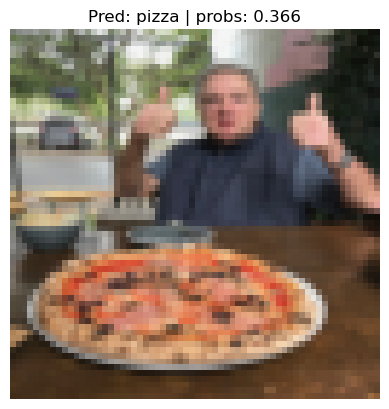

In [375]:
# Pred on our custom image 
pred_and_plot_image(model=model_1, 
                   image_path=custom_image_path,
                   class_names=class_names,
                   transform=custom_image_transform,
                   device=device)